# Notebook Huấn luyện Model Nhận dạng Biển số xe

## Chuẩn bị: Kích hoạt GPU
Trước khi chạy bất cứ thứ gì, bạn cần đảm bảo đã bật GPU cho notebook này.
1. Trên thanh menu, chọn **Runtime**.
2. Chọn **Change runtime type**.
3. Trong mục `Hardware accelerator`, chọn **GPU**.
4. Trong mục `GPU type`, chọn **T4**.
5. Nhấn **Save**.

Cell code ngay bên dưới sẽ giúp bạn kiểm tra lại thông tin GPU đã nhận được.

In [ ]:
!nvidia-smi

Tue Nov  4 06:51:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Cài đặt Môi trường và Thư viện
Bước này sẽ cài đặt các thư viện cần thiết như `ultralytics` cho YOLO và các thư viện phụ trợ khác.

In [ ]:
%pip install ultralytics opencv-python pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.7 MB/s eta 0:00:00


## 2. Kết nối Google Drive
Chúng ta sẽ kết nối với Google Drive để có thể lưu trữ dataset, các file cấu hình, và trọng số (weights) của model đã huấn luyện.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Chuẩn bị Dataset từ file Zip
Sau khi đã upload file dataset vào Google Drive, tiến hành copy dataset sang máy ảo Colab và giải nén. Việc này giúp tăng tốc độ đọc ghi dữ liệu trong quá trình training.

In [ ]:
import os

os.makedirs('/content/license_plate_dataset', exist_ok=True)

!cp /content/drive/MyDrive/projects/license_plate_detection_recognition/training/dataset/LP_detection.zip /content/LP_detection.zip
!unzip -q /content/LP_detection.zip -d /content/license_plate_dataset/


**Hoặc** download trực tiếp dataset Google Drive

In [ ]:
# import os

# os.makedirs('/content/license_plate_dataset', exist_ok=True)

# !gdown https://drive.google.com/uc?id=1xchPXf7a1r466ngow_W_9bittRqQEf_T -O /content/dataset/LP_detection.zip
# !unzip -q /content/LP_detection.zip -d /content/license_plate_dataset/

## 4. Tạo file cấu hình `data.yaml`
Tạo file `data.yaml` tự động để trỏ đến các thư mục vừa giải nén trên máy ảo Colab.
Script này sẽ check checkpoint

In [ ]:
import yaml

data_yaml = {
    'train': '/content/license_plate_dataset/LP_detection/images/train',
    'val': '/content/license_plate_dataset/LP_detection/images/val',
    'nc': 1,
    'names': ['license_plate']
}

with open('/content/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=False)

%cat /content/data.yaml

names:
- license_plate
nc: 1
train: /content/license_plate_dataset/LP_detection/images/train
val: /content/license_plate_dataset/LP_detection/images/val


## 5. Huấn luyện Model YOLO (Detection)
Bắt đầu quá trình training với các tham số đã được tối ưu cho GPU T4.

*Nếu quá trình training bị timeout, chỉ cần chạy lại để tiếp tục train, nhờ cơ chế resume từ checkpoint gần nhất.*

In [ ]:
from ultralytics import YOLO
import os

project_path = '/content/drive/MyDrive/model_license_plate_runs'
exp_name = 'exp'
weights_path = os.path.join(project_path, exp_name, 'weights', 'last.pt')

# Check exsting checkpoint
if os.path.exists(weights_path):
    print(f"Checkpoint found: {weights_path}")
    model = YOLO(weights_path)
    results = model.train(
        data='/content/data.yaml',
        epochs=100,
        resume=True
    )
else:
    print("Checkpoint not found. Starting training from scratch.")
    model = YOLO('yolo11n.pt')
    results = model.train(
        data='/content/data.yaml',
		epochs=100,
		imgsz=640,
		batch=16,
		device=0,
		workers=2,
		optimizer='Adam',
		lr0=0.001,
		patience=10,
        project=project_path,
        name=exp_name,
		verbose=True,
		save=True,
		save_period=5,
		val=True
    )


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Checkpoint found: /content/drive/MyDrive/model_license_plate_runs/exp/weights/last.pt
Ultralytics 8.3.224 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fals

## 6. Test Model
Sau khi training, thực hiện test model với ảnh thực tế.


image 1/1 /content/license_plate_dataset/LP_detection/images/val/CarLongPlate44.jpg: 416x640 1 license_plate, 73.9ms
Speed: 3.0ms preprocess, 73.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


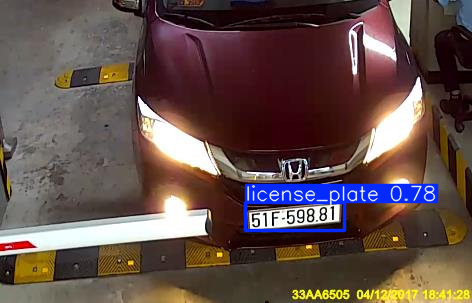

In [ ]:
# Tải model tốt nhất đã được huấn luyện
best_model = YOLO('/content/drive/MyDrive/model_license_plate_runs/exp/weights/best.pt')

# Test ảnh từ dataset
results = best_model('/content/license_plate_dataset/LP_detection/images/val/CarLongPlate44.jpg')

# Process results
for r in results:
    boxes = r.boxes
    r.show()

--2025-11-04 07:54:33--  https://vnn-imgs-f.vgcloud.vn/2019/05/22/16/khong-chi-ngu-quy-xe-may-bien-so-sanh-gia-khung-khong-kem-3.jpg
Resolving vnn-imgs-f.vgcloud.vn (vnn-imgs-f.vgcloud.vn)... 123.30.148.5, 123.30.148.6
Connecting to vnn-imgs-f.vgcloud.vn (vnn-imgs-f.vgcloud.vn)|123.30.148.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg          [     <=>            ] 257.04K   256KB/s    in 1.0s    

2025-11-04 07:54:37 (256 KB/s) - ‘test_image.jpg’ saved [263214]


image 1/1 /content/test_image.jpg: 544x640 4 license_plates, 83.4ms
Speed: 5.4ms preprocess, 83.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


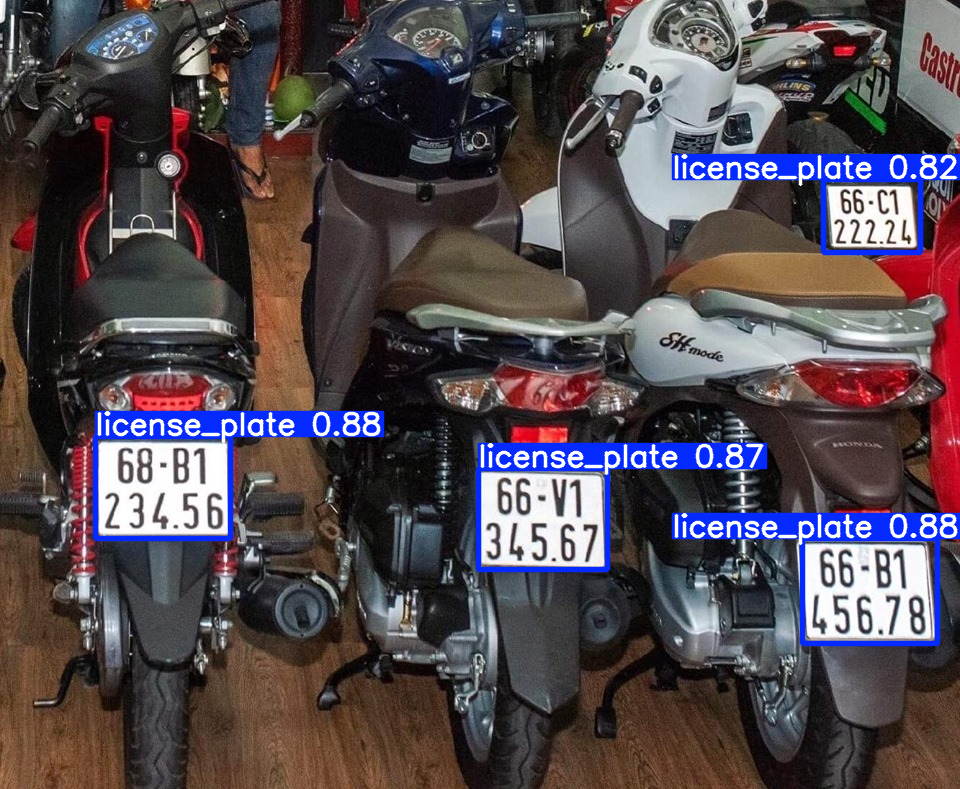

In [ ]:
# Download test image from internet
!wget https://vnn-imgs-f.vgcloud.vn/2019/05/22/16/khong-chi-ngu-quy-xe-may-bien-so-sanh-gia-khung-khong-kem-3.jpg -O test_image.jpg

# Tải model tốt nhất đã được huấn luyện
best_model = YOLO('/content/drive/MyDrive/model_license_plate_runs/exp/weights/best.pt')
results = best_model('/content/test_image.jpg')

# Process results
for r in results:
    boxes = r.boxes
    r.show()